# Things you might think of implementing  
- replay buffer to learn from unconnected experiences 
- train in batches to make everything more efficient.
- implement PPO, instantiating 2 actors. 1 will be the baseline (i.e. the previous update) in order to compute the ratio.
- define 2 different actors that will be specific for each agent. overfitting is possible.
- try to see whether you can use convolutions

# Imports

In [1]:
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld, OvercookedState
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.agents.agent import Agent, AgentPair, RandomAgent
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict

# Useful classes 

Policy class: NN for computing the probability distribution of the actions to take.

In [ ]:
class Policy(Model):
    def __init__(self, input_shape, num_actions, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(128, activation='tanh')
        self.policy_a = layers.Dense(self.num_actions, activation='softmax', name="policy_a")
        self.policy_b = layers.Dense(self.num_actions, activation='softmax', name="policy_b")
        self.build_model()
    
    def preprocess(self, obs):
        agent_1_obs = obs['both_agent_obs'][0]
        agent_2_obs = obs['both_agent_obs'][1]
        return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
      

    def call(self, obs, training=False):
        x = self.preprocess(obs)
        x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        policy_a = self.policy_a(x)
        policy_b = self.policy_b(x)
        return (policy_a, policy_b)

    def build_model(self):
        # computing a forward pass in order to automatically build the model
        dummy_input = {
        "both_agent_obs": (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        }
        _ = self(dummy_input) 
    
    def train_step(self, delta, obs: Tuple, action: Tuple[int,int]):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs, training=True)
            log_pi = tf.math.log(pi) 
            pi_a = log_pi[0][..., action[0]] + log_pi[1][..., action[1]] # π(A|S), computing the sum of the probability of the best actions
        
        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        processed_gradient = [-tf.squeeze(delta)*grad for grad in grad_pi_a]
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))

ValueFunctionApproximator class: NN for approximating the value function of a given state.

In [ ]:
class ValueFunctionApproximator(Model):
    def __init__(self, input_shape, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(128, activation='tanh')
        # self.value_function = layers.Dense(1, activation='relu', name="value_function")
        self.value_function = layers.Dense(1, name="value_function")
        self.build_model()
    
    def preprocess(self, obs):
        agent_1_obs = obs['both_agent_obs'][0]
        agent_2_obs = obs['both_agent_obs'][1]
        return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
    

    def call(self, obs: Tuple, training=False):
        x = self.preprocess(obs)
        x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        value_function = self.value_function(x)
        return value_function

    def build_model(self): 
        # computing a forward pass in order to automatically build the model
        dummy_input = {
        "both_agent_obs": (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        }
        _ = self(dummy_input)
    
    def train_step(self, delta, obs: Tuple):
        # update w with w + alpha_w*delta*grad_v^(St)
        with tf.GradientTape() as tape:
            state_value = self.call(obs, training=True)
        
        grad_state_value = tape.gradient(state_value, self.trainable_weights)
        processed_gradient = [-tf.squeeze(delta)*grad for grad in grad_state_value]
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))


Agent class: inherits from Agent class found in agent.py

In [ ]:
class MyAgent(Agent):
    """
    This class is more a couple of actors since we use shared networks and the output are 2!!!
    For now let's treat it like a single player identified by self.index
    """
    def __init__(self, actor, critic, idx, base_env: OvercookedEnv, epsilon = 0.1):
        super().__init__()
        self.actor = actor
        self.critic = critic
        self.idx = idx
        if not self.idx in [0,1]:
            raise AssertionError("The index of the agent must be either 0 or 1!")
        self.base_env = base_env
        self.epsilon = epsilon

    def action(self, obs):
        """
        obs: preprocessed observation (or overcookedstate)
        We want to output the action given the state. can use a NN!
        should return a tuple (Action, Dict)
        Dict should contain info about the action ('action_probs': numpy array)
        """
        if isinstance(obs, OvercookedState):
            # this is useful for translating the OvercookedState 
            # into observation that can be fed into the NN.
            state = obs
            obs_from_state = self.base_env.featurize_state_mdp(state)
            obs = {'both_agent_obs': obs_from_state, 'overcooked_state': state}
    
        action_probs = self.actor.call(obs)[self.idx].numpy()
        if np.random.random() > self.epsilon: 
            action = Action.argmax(action_probs) # greedy selection
        else:
            action_idx = np.random.choice(range(0,6), size=1)[0]
            action = Action.INDEX_TO_ACTION[action_idx] # random exploration
        return (action, {'action_probs': action_probs})

    def actions(self, obss):
        """
        Look at the documentation of the Agent class
        """
        pass

    def update(self, obs, reward):
        """
        What do we need to update?
        """
        pass

    def decay_epsilon(self, decay):
        if self.epsilon - decay <= 0.05:
            self.epsilon = 0.05
        else:
            self.epsilon -= decay

# Let's start coding!

Let's define our environment:

In [ ]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

Let's instantiate our networks and the hyperparameters:

In [ ]:
alpha_w = 1e-5
alpha_t = 1e-6
critic_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [ ]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

shared_critic = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_optimizer
    )

In [ ]:
path_critic = "networks/critic/"
path_actor = "networks/actor/"

In [ ]:
shared_critic.load_weights(path_critic + "shared_critic.weights.h5")
shared_actor.load_weights(path_actor + "shared_actor.weights.h5")

Let's instantiate our agents:

In [ ]:
agent_1 = MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx=0,
    base_env=base_env,
    epsilon=0.5
)
agent_2 = MyAgent(
    actor=shared_actor,
    critic=shared_critic,
    idx=1,
    base_env=base_env,
    epsilon=0.5
)

Let's define our training loop! Let's go for now for a bootstrapping method.

In [ ]:
number_of_episodes = 1
last_actor_call = 0 # debugging
stop_calling = False # debugging
try:
    for episode in range(number_of_episodes):
        t = 0
        obs = env.reset()
        done = False
        shaped_reward_factor = 1 # multiplicative factor for discounting shaped reward.
        discount_rate = 1 # will decrease the shaped reward every time
        cumulative_reward = 0
        updated = False

        if stop_calling: # debugging
            break # debugging

        if (episode + 1) % 50 == 0:
            agent_1.decay_epsilon(decay=0.1)
            agent_2.decay_epsilon(decay=0.1)

        while not done:
            action1 = agent_1.action(obs)
            action2 = agent_2.action(obs)
            player_1_action = Action.ACTION_TO_INDEX[action1[0]]
            player_2_action = Action.ACTION_TO_INDEX[action2[0]]
            action = (player_1_action, player_2_action)

            new_obs, reward, done, env_info = env.step(action)
            shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.

            if shaped_reward != 0:
                shaped_reward = shaped_reward * shaped_reward_factor # discounting the shaped reward
                shaped_reward_factor *= discount_rate

            total_reward = reward + shaped_reward

            cumulative_reward += total_reward

            # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
            if done:
                delta = total_reward - shared_critic.call(obs)
            else:
                delta = total_reward + shared_critic.call(new_obs) - shared_critic.call(obs)
            
            if not stop_calling: # debugging
                last_actor_call = shared_actor.call(obs) # debugging
            
            if delta != 0:
                updated = True
                # update w with w + alpha_w*delta*grad_v^(St)
                shared_critic.train_step(delta, obs)        
                # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
                shared_actor.train_step(delta, obs, action)

                # DEBUGGING
                if not np.sum(shared_actor.call(obs)[1].numpy()) > 0.9:
                    print(delta)
                    stop_calling = True
                    break
                # END DEBUGGING
            # update state (obs = new_obs) 
            obs = new_obs  

            # think about training the critic by itself for a while
            t += 1
            
        print(f"Episode [{episode+1:>3d}] terminated at timestep {t}. cumulative reward: {cumulative_reward:>3d}. updated: {updated}")
        shared_critic.save_weights(path_critic + "shared_critic.weights.h5")
        shared_actor.save_weights(path_actor + "shared_actor.weights.h5")
except KeyboardInterrupt:
    shared_critic.save_weights(path_critic + "shared_critic.weights.h5")
    shared_actor.save_weights(path_actor + "shared_actor.weights.h5")
    print("User interrupted training. Saving weights")

In [ ]:
print("final frame: ")
render = env.render() / 255.0
plt.imshow(render)
plt.show()

next step: a metric!! let's plot the reward over time.

In [ ]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": 400})

agent_1.epsilon = 0.1
agent_2.epsilon = 0.1
ap = AgentPair(agent_1, agent_2)

trajs = ae.evaluate_agent_pair(ap, 10)
# trajs = ae.evaluate_human_model_pair(1)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

In [ ]:
shared_actor.call(new_obs)

# Using trajectories
 When evaluating trajectory of my agents, the agents are fed with the overcooked state.  
 Since my agent use the "both_agent_obs", i can convert the overcooked state in "both_agent_obs" through base_env.featurize_state_mdp(state).  
 The problem here is that i need to pay attention to the index since this method returns always in the POV of agent 0.  
 What i can do is to retrieve the index with env.agent_idx and i will have the following equality:  
 base_env.featurize_state_mdp(state)[0] == obs['both_agent_obs'][env.agent_idx]  
 I need to find a way to include the environment on my agent class and be able to call the agent_idx in order to preprocess the state and use the right order. 
 During testing this should not be a huge problem since our network should be able to generalize the position... let's do without it!

In [ ]:
obs = env.reset()
state = obs['overcooked_state']
transformed_obs = base_env.featurize_state_mdp(state)
print(env.agent_idx)
transformed_obs[env.agent_idx] == obs['both_agent_obs'][0]


# Let's try implementing PPO with batches
The idea is to compute some steps in the episode (let's say the whole episode), then you perform stochastic gradient descent with batches. the batch is the whole episode, and you train on minibatches of the episode, performing multiple epochs (let's say 10.)  
`Note:` THIS IS STILL ACTOR CRITIC KINDA

In [268]:
class PolicyBatch(Model):
    def __init__(self, input_shape, num_actions, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(128, activation='tanh')
        self.policy_a = layers.Dense(self.num_actions, activation='softmax', name="policy_a")
        self.policy_b = layers.Dense(self.num_actions, activation='softmax', name="policy_b")
        self.build_model()
    
    def preprocess(self, obs_batch):
        if isinstance(obs_batch, Tuple):
            obs_batch = [obs_batch] # to handle the case where obs_batch is a single observation
            
        obs_1, obs_2 = zip(*obs_batch)
        obs_batch = tf.concat([tf.stack(obs_1), tf.stack(obs_2)], axis=-1)
        return obs_batch
      

    def call(self, obs_batch, training=False):
        x = self.preprocess(obs_batch)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        policy_a = self.policy_a(x)
        policy_b = self.policy_b(x)
        return (policy_a, policy_b) # self.call(obs_batch)[0][N]: n-th policy of agent 1 

    def build_model(self):
        # computing a forward pass in order to automatically build the model
        dummy_input = (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        _ = self(dummy_input) 
    
    def train_step(self, deltas_batch: tf.Tensor, obs_batch, actions_batch):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs_batch, training=True)
            log_pi = tf.math.log(pi) 
            processed_log_pi = -deltas_batch * log_pi
            pi_a = 0
            for i in range(len(actions_batch)):
                pi_a += processed_log_pi[0][i][actions_batch[i][0]] + processed_log_pi[1][i][actions_batch[i][1]]

        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_pi_a, self.trainable_weights))


class ValueFunctionApproximatorBatch(Model):
    def __init__(self, input_shape, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(128, activation='tanh')
        # self.value_function = layers.Dense(1, activation='relu', name="value_function")
        self.value_function = layers.Dense(1, name="value_function")
        self.build_model()
    
    def preprocess(self, obs_batch):
        if isinstance(obs_batch, Tuple):
            obs_batch = [obs_batch] # to handle the case where obs_batch is a single observation
            
        obs_1, obs_2 = zip(*obs_batch)
        obs_batch = tf.concat([tf.stack(obs_1), tf.stack(obs_2)], axis=-1)
        return obs_batch
    

    def call(self, obs_batch, training=False):
        x = self.preprocess(obs_batch)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        value_function = self.value_function(x)
        return value_function

    def build_model(self): 
        # computing a forward pass in order to automatically build the model
        dummy_input =  (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        _ = self(dummy_input)
    
    def train_step(self, deltas_batch: tf.Tensor, obs_batch): # deltas is a tf.Tensor of shape (batch_size,1)
        # update w with w + alpha_w*grad_v^(St)*delta
        with tf.GradientTape() as tape:
            state_value = self.call(obs_batch, training=True)
            loss = tf.reduce_mean(tf.square(deltas_batch)) # adding a term that minimizes the distance between the true and the estimated value 
            processed_state_value = -deltas_batch * state_value + loss
        
        grad_state_value = tape.gradient(processed_state_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_state_value, self.trainable_weights))

class MyAgentBatch(Agent):
    """
    This class is more a couple of actors since we use shared networks and the output are 2!!!
    For now let's treat it like a single player identified by self.index
    """
    def __init__(self, actor, critic, idx, base_env: OvercookedEnv, epsilon = 0.1):
        super().__init__()
        self.actor = actor
        self.critic = critic
        self.idx = idx
        if not self.idx in [0,1]:
            raise AssertionError("The index of the agent must be either 0 or 1!")
        self.base_env = base_env
        self.epsilon = epsilon

    def action(self, obs):
        """
        obs: preprocessed observation (or overcookedstate)
        We want to output the action given the state. can use a NN!
        should return a tuple (Action, Dict)
        Dict should contain info about the action ('action_probs': numpy array)
        """
        if isinstance(obs, OvercookedState):
            # this is useful for translating the OvercookedState 
            # into observation that can be fed into the NN.
            obs_from_state = self.base_env.featurize_state_mdp(obs)
            obs = (obs_from_state[0],obs_from_state[1])

    
        action_probs = self.actor.call(obs)[self.idx].numpy()
        if np.random.random() > self.epsilon: 
            action = Action.argmax(action_probs) # greedy selection
        else:
            action_idx = np.random.choice(range(0,6), size=1)[0]
            action = Action.INDEX_TO_ACTION[action_idx] # random exploration
        return (action, {'action_probs': action_probs})

    def actions(self, obss):
        """
        Look at the documentation of the Agent class
        """
        pass

    def update(self, obs, reward):
        """
        What do we need to update?
        """
        pass

    def decay_epsilon(self, decay):
        if self.epsilon - decay <= 0.5:
            self.epsilon = 0.5
        else:
            self.epsilon -= decay

In [269]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

alpha_t = 1e-5
alpha_w = 1e-5

optimizer_actor = Adam(learning_rate=alpha_t)
optimizer_critic = Adam(learning_rate=alpha_w)

input_shape = env.observation_space._shape

shared_actor_batch = PolicyBatch(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=optimizer_actor
)

shared_critic_batch = ValueFunctionApproximatorBatch(
    input_shape=input_shape,
    optimizer=optimizer_critic
    )

agent_1 = MyAgentBatch(
    actor=shared_actor_batch,
    critic=shared_critic_batch,
    idx=0,
    base_env=base_env,
    epsilon=0.9
)
agent_2 = MyAgentBatch(
    actor=shared_actor_batch,
    critic=shared_critic_batch,
    idx=1,
    base_env=base_env,
    epsilon=0.9
)

In [270]:
path_critic = "networks/critic/"
path_actor = "networks/actor/"

In [ ]:
shared_critic_batch.load_weights(path_critic + "shared_critic_batch5.weights.h5")
shared_actor_batch.load_weights(path_actor + "shared_actor_batch5.weights.h5")

In [271]:
number_of_episodes = 1
batch_size = 10 
number_of_epochs = 2
try:
    for episode in range(number_of_episodes):
        timestep = 0
        obs = env.reset()
        done = False

        shaped_reward_factor = 1 # multiplicative factor for discounting shaped reward.
        discount_rate = 1 # will decrease the shaped reward every time
        cumulative_reward = 0

        if (episode + 1) % 75 == 0:
            agent_1.decay_epsilon(decay=0.1)
            agent_2.decay_epsilon(decay=0.1)
            shared_critic_batch.save_weights(path_critic + "shared_critic_batch"+str(agent_1.epsilon)[2]+".weights.h5")
            shared_actor_batch.save_weights(path_actor + "shared_actor_batch"+str(agent_1.epsilon)[2]+".weights.h5")

        actions = []
        deltas = []
        observations = []
        rewards = []

        while not done:
            # reordering the actions based on the POV of the environment
            if obs['other_agent_env_idx'] == 0:
                my_obs = (obs['both_agent_obs'][1],obs['both_agent_obs'][0])
                obs['both_agent_obs'] = my_obs

            action1 = agent_1.action(obs['both_agent_obs'])
            action2 = agent_2.action(obs['both_agent_obs'])
            player_1_action = Action.ACTION_TO_INDEX[action1[0]]
            player_2_action = Action.ACTION_TO_INDEX[action2[0]]
            action = (player_1_action, player_2_action)

            actions.append(action)
            observations.append(obs['both_agent_obs'])

            new_obs, reward, done, env_info = env.step(action)
            shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.

            if shaped_reward != 0:
                shaped_reward = shaped_reward * shaped_reward_factor # discounting the shaped reward
                shaped_reward_factor *= discount_rate


            total_reward = reward + shaped_reward
            rewards.append(total_reward)
            cumulative_reward += total_reward

            # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
            # if done:
            #     delta = total_reward - shared_critic_batch.call(obs['both_agent_obs'])
            # else:
            #     delta = total_reward + shared_critic_batch.call(new_obs['both_agent_obs']) - shared_critic_batch.call(obs['both_agent_obs'])
                        
            # deltas.append(delta)

            # update state (obs = new_obs) 
            obs = new_obs  

            timestep += 1
            
        print(f"Episode [{episode+1:>3d}] terminated at timestep {timestep}. cumulative reward: {cumulative_reward:>3d}.")

        print(f"Computing the deltas (MONTE-CARLO)")
        for t in range(len(actions)):
            G_t = np.sum(rewards[t:])
            delta = G_t - shared_critic_batch.call(observations[t])
            deltas.append(delta)

        print(f"Performing stocastic gradient descent with {number_of_epochs} epochs.")
        for epoch in tqdm(range(number_of_epochs)):
            num_batches = len(actions) // batch_size
            shuffled_indices = tf.random.shuffle(tf.range(len(actions)))
            for batch in range(num_batches):
                if batch == num_batches: # last batch
                    idx = shuffled_indices[batch*batch_size:]
                else:
                    idx = shuffled_indices[batch*batch_size:(batch+1)*batch_size]

                deltas_batch = tf.squeeze(tf.gather(deltas, idx), axis=-1) 
                actions_batch = tf.gather(actions, idx)
                observations_batch = tf.gather(observations, idx)

                shared_critic_batch.train_step(deltas_batch, observations_batch)
                shared_actor_batch.train_step(deltas_batch, observations_batch, actions_batch)



        # shared_critic.save_weights(path_critic + "shared_critic.weights.h5")
        # shared_actor.save_weights(path_actor + "shared_actor.weights.h5")
except:
    shared_critic_batch.save_weights(path_critic + "shared_critic_batch.weights.h5")
    shared_actor_batch.save_weights(path_actor + "shared_actor_batch.weights.h5")
    print("Unexpected interruption of training. Saving weights")

Episode [  1] terminated at timestep 400. cumulative reward:  14.
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": 400})

agent_1.epsilon = 0.1
agent_2.epsilon = 0.1
ap = AgentPair(agent_1, agent_2)

trajs = ae.evaluate_agent_pair(ap, 10)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [ ]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": 400})

agent_1.epsilon = 0.1
agent_2.epsilon = 0.1
ap = AgentPair(agent_2, agent_1)

trajs = ae.evaluate_agent_pair(ap, 10)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [ ]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": 400})

ap = AgentPair(RandomAgent(all_actions=True), RandomAgent(all_actions=True))

trajs = ae.evaluate_agent_pair(ap, 10)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 2.00 (std: 6.00, se: 1.90); avg len: 400.00; : 100%|██████████| 10/10 [00:00<00:00, 10.71it/s]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

# TRIALS

In [ ]:
shared_critic_batch(observations)

In [ ]:
# obs = env.reset()
# new_obs, reward, done, env_info = env.step(action)

In [ ]:
obs['other_agent_env_idx']

0

In [ ]:
# ['agent_infos', 'sparse_r_by_agent', 'shaped_r_by_agent', 'phi_s', 'phi_s_prime', 'episode', 'policy_agent_idx']
env_info['episode']['ep_game_stats']['cumulative_sparse_rewards_by_agent']
env_info['episode']['ep_game_stats']['cumulative_shaped_rewards_by_agent']

{'tomato_pickup': [[], []],
 'useful_tomato_pickup': [[], []],
 'tomato_drop': [[], []],
 'useful_tomato_drop': [[], []],
 'potting_tomato': [[], []],
 'onion_pickup': [[92, 152, 181, 341, 357], [1, 19, 44, 80]],
 'useful_onion_pickup': [[92, 152, 181, 341, 357], [1, 19, 44, 80]],
 'onion_drop': [[111, 252, 353], [18, 73]],
 'useful_onion_drop': [[], []],
 'potting_onion': [[177], [21, 90]],
 'dish_pickup': [[17, 45, 71, 74, 123, 269], [37, 97, 312, 384]],
 'useful_dish_pickup': [[], []],
 'dish_drop': [[44, 70, 73, 90, 145, 323], [39, 304, 383]],
 'useful_dish_drop': [[44, 145], [39]],
 'soup_pickup': [[], [387]],
 'soup_delivery': [[], []],
 'soup_drop': [[], [399]],
 'optimal_onion_potting': [[177], [21, 90]],
 'optimal_tomato_potting': [[], []],
 'viable_onion_potting': [[177], [21, 90]],
 'viable_tomato_potting': [[], []],
 'catastrophic_onion_potting': [[], []],
 'catastrophic_tomato_potting': [[], []],
 'useless_onion_potting': [[], []],
 'useless_tomato_potting': [[], []],
 'cu

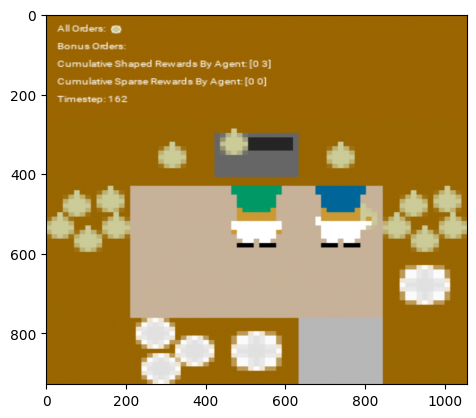

In [ ]:
render = env.render() / 255.0
plt.imshow(render)
plt.show()

# Let's use different NNs for the agents:

In [2]:
class SinglePolicyBatch(Model):
    def __init__(self, input_shape, num_actions, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(128, activation='tanh')
        self.policy = layers.Dense(self.num_actions, activation='softmax', name="policy")
        self.build_model()
    
    def preprocess(self, obs_batch):
        if isinstance(obs_batch, Tuple):
            obs_batch = [obs_batch] # to handle the case where obs_batch is a single observation
            
        obs_1, obs_2 = zip(*obs_batch)
        obs_batch = tf.concat([tf.stack(obs_1), tf.stack(obs_2)], axis=-1)
        return obs_batch
      

    def call(self, obs_batch, training=False):
        x = self.preprocess(obs_batch)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        policy = self.policy(x)
        return policy

    def build_model(self):
        # computing a forward pass in order to automatically build the model
        dummy_input = (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        _ = self(dummy_input) 
    
    def train_step(self, deltas_batch: tf.Tensor, obs_batch, actions_batch):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs_batch, training=True)
            log_pi = tf.math.log(pi) 
            processed_log_pi = -deltas_batch * log_pi
            pi_a = 0
            for i in range(len(actions_batch)):
                # THIS NEED TO BE MODIFIED
                pi_a += processed_log_pi[i][actions_batch[i]]

        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_pi_a, self.trainable_weights))


class SingleValueFunctionApproximatorBatch(Model):
    def __init__(self, input_shape, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(128, activation='tanh')
        # self.value_function = layers.Dense(1, activation='relu', name="value_function")
        self.value_function = layers.Dense(1, name="value_function")
        self.build_model()
    
    def preprocess(self, obs_batch):
        if isinstance(obs_batch, Tuple):
            obs_batch = [obs_batch] # to handle the case where obs_batch is a single observation
            
        obs_1, obs_2 = zip(*obs_batch)
        obs_batch = tf.concat([tf.stack(obs_1), tf.stack(obs_2)], axis=-1)
        return obs_batch
    

    def call(self, obs_batch, training=False):
        x = self.preprocess(obs_batch)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        value_function = self.value_function(x)
        return value_function

    def build_model(self): 
        # computing a forward pass in order to automatically build the model
        dummy_input =  (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        _ = self(dummy_input)
    
    def train_step(self, deltas_batch: tf.Tensor, obs_batch): # deltas is a tf.Tensor of shape (batch_size,1)
        # update w with w + alpha_w*grad_v^(St)*delta
        with tf.GradientTape() as tape:
            state_value = self.call(obs_batch, training=True)
            loss = tf.reduce_mean(tf.square(deltas_batch)) # adding a term that minimizes the distance between the true and the estimated value 
            processed_state_value = -deltas_batch * state_value + loss
        
        grad_state_value = tape.gradient(processed_state_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_state_value, self.trainable_weights))

class SingleMyAgentBatch(Agent):
    """
    This class implements a single Agent
    For now let's treat it like a single player identified by self.index
    """
    def __init__(self, actor, critic, idx, base_env: OvercookedEnv, epsilon = 0.1):
        super().__init__()
        self.actor = actor
        self.critic = critic
        self.idx = idx
        if not self.idx in [0,1]:
            raise AssertionError("The index of the agent must be either 0 or 1!")
        self.base_env = base_env
        self.epsilon = epsilon

    def action(self, obs):
        """
        obs: preprocessed observation (or overcookedstate)
        We want to output the action given the state. can use a NN!
        should return a tuple (Action, Dict)
        Dict should contain info about the action ('action_probs': numpy array)
        """
        if isinstance(obs, OvercookedState):
            # this is useful for translating the OvercookedState 
            # into observation that can be fed into the NN.
            obs_from_state = self.base_env.featurize_state_mdp(obs)
            obs = (obs_from_state[0],obs_from_state[1])

    
        action_probs = self.actor.call(obs).numpy()
        if np.random.random() > self.epsilon: 
            action = Action.argmax(action_probs) # greedy selection
        else:
            action_idx = np.random.choice(range(0,6), size=1)[0]
            action = Action.INDEX_TO_ACTION[action_idx] # random exploration
        return (action, {'action_probs': action_probs})

    def actions(self, obss):
        """
        Look at the documentation of the Agent class
        """
        pass

    def update(self, obs, reward):
        """
        What do we need to update?
        """
        pass

    def decay_epsilon(self, decay):
        if self.epsilon - decay <= 0.5:
            self.epsilon = 0.5
        else:
            self.epsilon -= decay

In [ ]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

alpha_t = 1e-5
alpha_w = 1e-5

optimizer_actor_1 = Adam(learning_rate=alpha_t)
optimizer_actor_2 = Adam(learning_rate=alpha_t)
optimizer_critic_1 = Adam(learning_rate=alpha_w)
optimizer_critic_2 = Adam(learning_rate=alpha_w)

input_shape = env.observation_space._shape

single_actor_batch_1 = SinglePolicyBatch(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=optimizer_actor_1
)
single_actor_batch_2 = SinglePolicyBatch(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=optimizer_actor_2
)

single_critic_batch_1 = SingleValueFunctionApproximatorBatch(
    input_shape=input_shape,
    optimizer=optimizer_critic_1
    )

single_critic_batch_2 = SingleValueFunctionApproximatorBatch(
    input_shape=input_shape,
    optimizer=optimizer_critic_2
    )

agent_1 = SingleMyAgentBatch(
    actor=single_actor_batch_1,
    critic=single_critic_batch_1,
    idx=0,
    base_env=base_env,
    epsilon=0.9
)
agent_2 = SingleMyAgentBatch(
    actor=single_actor_batch_2,
    critic=single_critic_batch_2,
    idx=1,
    base_env=base_env,
    epsilon=0.9
)

In [6]:
path_critic = "networks/critic/"
path_actor = "networks/actor/"

In [12]:
number_of_episodes = 10
batch_size = 10 
number_of_epochs = 2
try:
    for episode in range(number_of_episodes):
        timestep = 0
        obs = env.reset()
        done = False

        shaped_reward_factor = 1 # multiplicative factor for discounting shaped reward.
        discount_rate = 1 # will decrease the shaped reward every time
        cumulative_reward = 0

        if (episode + 1) % 75 == 0:
            agent_1.decay_epsilon(decay=0.1)
            agent_2.decay_epsilon(decay=0.1)
            single_critic_batch_1.save_weights(path_critic + "single_critic_batch_1_"+str(agent_1.epsilon)[2]+".weights.h5")
            single_critic_batch_2.save_weights(path_critic + "single_critic_batch_2_"+str(agent_1.epsilon)[2]+".weights.h5")
            single_actor_batch_1.save_weights(path_actor + "single_actor_batch_1"+str(agent_2.epsilon)[2]+".weights.h5")
            single_actor_batch_2.save_weights(path_actor + "single_actor_batch_2"+str(agent_2.epsilon)[2]+".weights.h5")

        agent_1_actions = []
        agent_2_actions = []
        agent_1_deltas = []
        agent_2_deltas = []
        agent_1_rewards = []
        agent_2_rewards = []
        observations = []

        while not done:
            # reordering the actions based on the POV of the environment
            if obs['other_agent_env_idx'] == 0:
                my_obs = (obs['both_agent_obs'][1],obs['both_agent_obs'][0])
                obs['both_agent_obs'] = my_obs

            action1 = agent_1.action(obs['both_agent_obs'])
            action2 = agent_2.action(obs['both_agent_obs'])
            player_1_action = Action.ACTION_TO_INDEX[action1[0]]
            player_2_action = Action.ACTION_TO_INDEX[action2[0]]
            action = (player_1_action,player_2_action)

            agent_1_actions.append(player_1_action)
            agent_2_actions.append(player_2_action)
            observations.append(obs['both_agent_obs'])

            new_obs, reward, done, env_info = env.step(action)
            # shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.
            agent_1_shaped_reward = env_info['shaped_r_by_agent'][0]
            agent_2_shaped_reward = env_info['shaped_r_by_agent'][1]
            
            # if shaped_reward != 0:
            #     shaped_reward = shaped_reward * shaped_reward_factor # discounting the shaped reward
            #     shaped_reward_factor *= discount_rate


            agent_1_total_reward = reward + agent_1_shaped_reward
            agent_2_total_reward = reward + agent_2_shaped_reward
            agent_1_rewards.append(agent_1_total_reward)
            agent_2_rewards.append(agent_2_total_reward)
            cumulative_reward += (agent_1_total_reward + agent_2_total_reward - reward) # since it's in both the total rewards

            obs = new_obs  

            timestep += 1
            
        print(f"Episode [{episode+1}] terminated at timestep {timestep}. cumulative reward: {cumulative_reward}.")
        
        print(f"cumulative sparse reward: {env_info['episode']['ep_game_stats']['cumulative_sparse_rewards_by_agent']}")
        print(f"cumulative shaped reward: {env_info['episode']['ep_game_stats']['cumulative_shaped_rewards_by_agent']}")

        print(f"Computing the deltas (MONTE-CARLO)")
        for t in range(len(observations)):
            G_t_agent_1 = np.sum(agent_1_rewards[t:])
            G_t_agent_2 = np.sum(agent_2_rewards[t:])
            agent_1_delta = G_t_agent_1 - single_critic_batch_1.call(observations[t])
            agent_2_delta = G_t_agent_2 - single_critic_batch_2.call(observations[t])
            agent_1_deltas.append(agent_1_delta)
            agent_2_deltas.append(agent_2_delta)

        print(f"Performing stocastic gradient descent with {number_of_epochs} epochs.")
        for epoch in tqdm(range(number_of_epochs)):
            num_batches = len(observations) // batch_size
            shuffled_indices = tf.random.shuffle(tf.range(len(observations)))
            for batch in range(num_batches):
                if batch == num_batches: # last batch
                    idx = shuffled_indices[batch*batch_size:]
                else:
                    idx = shuffled_indices[batch*batch_size:(batch+1)*batch_size]

                agent_1_deltas_batch = tf.squeeze(tf.gather(agent_1_deltas, idx), axis=-1) 
                agent_2_deltas_batch = tf.squeeze(tf.gather(agent_2_deltas, idx), axis=-1) 
                agent_1_actions_batch = tf.gather(agent_1_actions, idx)
                agent_2_actions_batch = tf.gather(agent_2_actions, idx)
                observations_batch = tf.gather(observations, idx)

                single_critic_batch_1.train_step(agent_1_deltas_batch, observations_batch)
                single_critic_batch_2.train_step(agent_2_deltas_batch, observations_batch)
                single_actor_batch_1.train_step(agent_1_deltas_batch, observations_batch, agent_1_actions_batch)
                single_actor_batch_2.train_step(agent_2_deltas_batch, observations_batch, agent_2_actions_batch)

except KeyboardInterrupt:
    single_critic_batch_1.save_weights(path_critic + "single_critic_batch_1_"+str(agent_1.epsilon)[2]+".weights.h5")
    single_critic_batch_2.save_weights(path_critic + "single_critic_batch_2_"+str(agent_1.epsilon)[2]+".weights.h5")
    single_actor_batch_1.save_weights(path_actor + "single_actor_batch_1"+str(agent_1.epsilon)[2]+".weights.h5")
    single_actor_batch_2.save_weights(path_actor + "single_actor_batch_2"+str(agent_1.epsilon)[2]+".weights.h5")
    print("Unexpected interruption of training. Saving weights")

Episode [1] terminated at timestep 400. cumulative reward: 6.
cumulative sparse reward: [0 0]
cumulative shaped reward: [0 6]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [2] terminated at timestep 400. cumulative reward: 6.
cumulative sparse reward: [0 0]
cumulative shaped reward: [3 3]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [3] terminated at timestep 400. cumulative reward: 9.
cumulative sparse reward: [0 0]
cumulative shaped reward: [6 3]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [4] terminated at timestep 400. cumulative reward: 11.
cumulative sparse reward: [0 0]
cumulative shaped reward: [11  0]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [5] terminated at timestep 400. cumulative reward: 14.
cumulative sparse reward: [0 0]
cumulative shaped reward: [11  3]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [6] terminated at timestep 400. cumulative reward: 16.
cumulative sparse reward: [0 0]
cumulative shaped reward: [11  5]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [7] terminated at timestep 400. cumulative reward: 8.
cumulative sparse reward: [0 0]
cumulative shaped reward: [3 5]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [8] terminated at timestep 400. cumulative reward: 8.
cumulative sparse reward: [0 0]
cumulative shaped reward: [5 3]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [9] terminated at timestep 400. cumulative reward: 9.
cumulative sparse reward: [0 0]
cumulative shaped reward: [6 3]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]

Episode [10] terminated at timestep 400. cumulative reward: 3.
cumulative sparse reward: [0 0]
cumulative shaped reward: [0 3]
Computing the deltas (MONTE-CARLO)
Performing stocastic gradient descent with 2 epochs.


  0%|          | 0/2 [00:00<?, ?it/s]